In [1]:
import boto3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import requests
import time

In [2]:
# NOTE: You will need to set AWS access keys for the MCP environment

In [2]:
%%time
client = boto3.client('logs', region_name='us-west-2')

concept_type = "collections"
query = """
fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like "Searching for """ + concept_type + '"' + """
| filter @message like "short_name"
| parse @message /:short_name "(?<short_name>(\w|-)+)"/
| stats count(*) as number_queries by short_name
| sort by number_queries desc
"""

print(query)
log_group = 'cmr-search-ops'
datetime_str = '05/18/22 00:00:00'
starting_datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

start_query_response = client.start_query(
    logGroupName=log_group,
    startTime=int(starting_datetime_object.timestamp()),
    endTime=int(datetime.now().timestamp()),
    queryString=query,
)

query_id = start_query_response['queryId']

logs_response = None

while logs_response == None or logs_response['status'] == 'Running':
    print('Waiting for query to complete ...')
    time.sleep(10)
    logs_response = client.get_query_results(
        queryId=query_id
    )


fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like "Searching for collections"
| filter @message like "short_name"
| parse @message /:short_name "(?<short_name>(\w|-)+)"/
| stats count(*) as number_queries by short_name
| sort by number_queries desc

Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complet

In [3]:
# Save the results so we don't have to re-run the query
filename = f"{concept_type}_short_name_search-{query_id}.json"
with open(filename, "w+") as f:
    f.write(json.dumps(logs_response))
    f.close()

In [4]:
data = json.loads(open(filename).read())
data

{'results': [[{'field': 'short_name', 'value': 'SRTMGL1_COD'},
   {'field': 'number_queries', 'value': '111'}],
  [{'field': 'short_name', 'value': 'L2_USER_DATA'},
   {'field': 'number_queries', 'value': '27'}],
  [{'field': 'short_name', 'value': 'AFRISAR_DLR'},
   {'field': 'number_queries', 'value': '11'}],
  [{'field': 'short_name', 'value': 'BIOSAR1'},
   {'field': 'number_queries', 'value': '11'}],
  [{'field': 'short_name', 'value': 'GEDI_L4B_Gridded_Biomass_2017'},
   {'field': 'number_queries', 'value': '9'}],
  [{'field': 'short_name', 'value': 'nceo_africa_2017'},
   {'field': 'number_queries', 'value': '4'}],
  [{'field': 'short_name', 'value': 'Polarimetric_CT_1601'},
   {'field': 'number_queries', 'value': '4'}],
  [{'field': 'short_name', 'value': 'GEDI02_A'},
   {'field': 'number_queries', 'value': '3'}],
  [{'field': 'short_name', 'value': 'GEDIL4B'},
   {'field': 'number_queries', 'value': '2'}],
  [{'field': 'short_name', 'value': 'GEDI01_B'},
   {'field': 'number_q

In [5]:
restructured_data = []
for result in logs_response['results']:
    entry_data = {}
    for entry in result:
        entry_data[entry['field']] = entry['value']
    restructured_data.append(entry_data)

restructured_data

[{'short_name': 'SRTMGL1_COD', 'number_queries': '111'},
 {'short_name': 'L2_USER_DATA', 'number_queries': '27'},
 {'short_name': 'AFRISAR_DLR', 'number_queries': '11'},
 {'short_name': 'BIOSAR1', 'number_queries': '11'},
 {'short_name': 'GEDI_L4B_Gridded_Biomass_2017', 'number_queries': '9'},
 {'short_name': 'nceo_africa_2017', 'number_queries': '4'},
 {'short_name': 'Polarimetric_CT_1601', 'number_queries': '4'},
 {'short_name': 'GEDI02_A', 'number_queries': '3'},
 {'short_name': 'GEDIL4B', 'number_queries': '2'},
 {'short_name': 'GEDI01_B', 'number_queries': '2'},
 {'short_name': 'PoLInSAR_Canopy_Height_1589', 'number_queries': '2'},
 {'short_name': 'AFLVIS2', 'number_queries': '1'},
 {'short_name': 'ATL08', 'number_queries': '1'}]

In [6]:
count_data = {}

for result in restructured_data:
    if 'short_name' in result:
        count_data[result['short_name']] = int(result['number_queries'])

count_data = {k: v for k, v in sorted(count_data.items(), key=lambda item: item[1], reverse=True)}

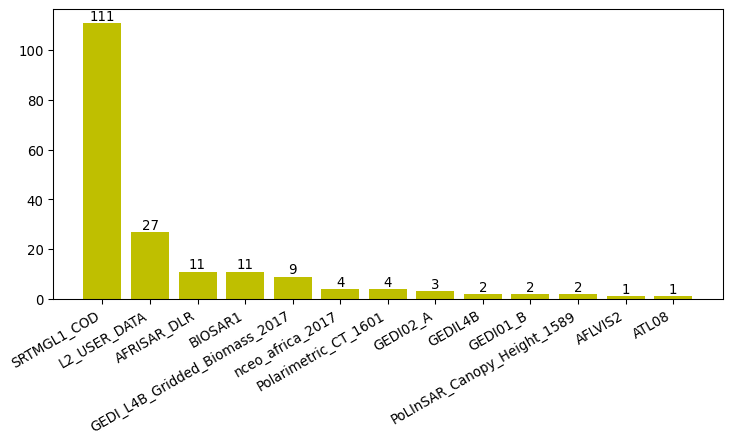

In [9]:
# data set
short_names = list(count_data.keys())
number_queries = list(count_data.values())

plt.figure(figsize=(9, 4), dpi=96)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', va= 'bottom')

plt.bar(short_names, number_queries, color='y')
addlabels(short_names, number_queries)
plt.xticks(rotation=30, ha='right')
plt.show()